In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Disable oneDNN custom operations if necessary
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [4]:
# Load the dataset
df = pd.read_csv('ws_updated.csv')

# Check for anomalies in the data
print(df.isnull().sum())
print(np.isinf(df).sum())
print(df.describe())

# Fill missing values and replace infinities
df.fillna(df.median(), inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Separate features and target
X = df.drop(columns=['Power'])
y = df['Power']

Temp 1        1008962
Pressure 2    1008962
Altitude 2    1008962
Light 1       1008962
UV            1008962
Humidity      1008962
Power         1008962
dtype: int64
Temp 1        0
Pressure 2    0
Altitude 2    0
Light 1       0
UV            0
Humidity      0
Power         0
dtype: int64
             Temp 1    Pressure 2    Altitude 2      Light 1            UV  \
count  34773.000000  34773.000000  34773.000000  34773.00000  3.477300e+04   
mean      36.222290    991.855345    179.683556  16074.76892  1.794758e+05   
std        7.536866      2.035099     17.248175   7560.81913  2.859980e+05   
min       22.500000    985.470000    151.430000      8.29000  0.000000e+00   
25%       30.000000    990.840000    167.860000   9721.04000  9.253800e+04   
50%       35.900000    991.870000    179.540000  18398.82000  2.525660e+05   
75%       42.500000    993.250000    188.260000  22695.32000  2.621430e+05   
max       52.000000    995.190000    233.880000  26390.94000  5.059379e+07   

     

In [36]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Normalize the target variable
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Reshape the features for LSTM [samples, timesteps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

6

In [34]:
# Define a smaller LSTM model
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model with a lower learning rate and Huber loss
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='huber')

c:\Users\Siddharth.Jani\Documents\code\test2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)

Epoch 1/2
20875/20875 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - loss: 3.5782e-04 - val_loss: 1.1247e-04
Epoch 2/2
20875/20875 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 1.0781e-04 - val_loss: 1.1079e-04


In [8]:
# Evaluate the model on test data
y_pred = model.predict(X_test)

6524/6524 ━━━━━━━━━━━━━━━━━━━━ 6s 813us/step


In [9]:
# Inverse transform predictions and true values
y_pred_inverse = y_scaler.inverse_transform(y_pred)
y_test_inverse = y_scaler.inverse_transform(y_test)

In [15]:
# Calculate Mean Squared Error
mse_value = np.mean((y_test_inverse - y_pred_inverse) ** 2)
print(f'Mean Squared Error on Test Data: {mse_value}')


Mean Squared Error on Test Data: 0.021587400484227325


In [23]:
import numpy as np

def ssa_decomposition_chunked(data, window_size, chunk_size):
    """Perform Singular Spectrum Analysis (SSA) on a time series in chunks."""
    N = len(data)
    result = np.zeros(N)

    for start in range(0, N, chunk_size):
        end = min(start + chunk_size, N)
        chunk_data = data[start:end]
        
        # Apply SSA on the chunk
        K = len(chunk_data) - window_size + 1
        if K > 0:
            X = np.array([chunk_data[i:i+window_size] for i in range(K)]).T
            print(f"Chunk shape {start}-{end}: {X.shape}")

            # Perform SVD
            U, Sigma, VT = np.linalg.svd(X)
            
            # Reconstruct the components
            components = np.array([np.outer(U[:, i], VT[i, :]) * Sigma[i] for i in range(len(Sigma))])
            
            # Correctly flatten and slice the reconstructed array
            reconstructed = np.zeros(len(chunk_data))
            w_matrix = np.zeros(len(chunk_data))
            
            for i in range(window_size):
                length = len(chunk_data) - window_size + i + 1
                reconstructed[i:length] += components[:, i].flatten()[:length - i]
                w_matrix[i:length] += 1
            
            reconstructed /= w_matrix
            print(f"Reconstructed shape for chunk {start}-{end}: {reconstructed.shape}")
            result[start:end] = reconstructed
        else:
            print(f"Skipping chunk {start}-{end} due to insufficient length")
    
    print(f"Final reconstructed shape: {result.shape}")
    return result

# Apply SSA to each feature in the dataset
X_ssa = np.array([ssa_decomposition_chunked(X[:, i], window_size=10, chunk_size=10000) for i in range(X.shape[1])]).T

# Normalize the SSA-transformed features
X_ssa_scaled = scaler.fit_transform(X_ssa)

# Reshape the features for LSTM [samples, timesteps, features]
X_ssa_scaled = X_ssa_scaled.reshape((X_ssa_scaled.shape[0], 1, X_ssa_scaled.shape[1]))


Chunk shape 0-10000: (10, 9991)
Reconstructed shape for chunk 0-10000: (10000,)
Chunk shape 10000-20000: (10, 9991)
Reconstructed shape for chunk 10000-20000: (10000,)
Chunk shape 20000-30000: (10, 9991)
Reconstructed shape for chunk 20000-30000: (10000,)
Chunk shape 30000-40000: (10, 9991)
Reconstructed shape for chunk 30000-40000: (10000,)
Chunk shape 40000-50000: (10, 9991)
Reconstructed shape for chunk 40000-50000: (10000,)
Chunk shape 50000-60000: (10, 9991)
Reconstructed shape for chunk 50000-60000: (10000,)
Chunk shape 60000-70000: (10, 9991)
Reconstructed shape for chunk 60000-70000: (10000,)
Chunk shape 70000-80000: (10, 9991)
Reconstructed shape for chunk 70000-80000: (10000,)
Chunk shape 80000-90000: (10, 9991)
Reconstructed shape for chunk 80000-90000: (10000,)
Chunk shape 90000-100000: (10, 9991)
Reconstructed shape for chunk 90000-100000: (10000,)
Chunk shape 100000-110000: (10, 9991)
Reconstructed shape for chunk 100000-110000: (10000,)
Chunk shape 110000-120000: (10, 99

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the SSA-transformed features
scaler = MinMaxScaler(feature_range=(0, 1))
X_ssa_scaled = scaler.fit_transform(X_ssa)

# Reshape the features for LSTM [samples, timesteps, features]
X_ssa_scaled = X_ssa_scaled.reshape((X_ssa_scaled.shape[0], 1, X_ssa_scaled.shape[1]))


In [25]:
from sklearn.model_selection import train_test_split

# Split the SSA-transformed and scaled data into training and testing sets
X_train_ssa, X_test_ssa, y_train_ssa, y_test_ssa = train_test_split(X_ssa_scaled, y, test_size=0.2, random_state=42)


In [26]:
# Define the LSTM model for SSA-transformed data
model_ssa = Sequential()
model_ssa.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_ssa.shape[1], X_train_ssa.shape[2])))
model_ssa.add(Dropout(0.2))
model_ssa.add(LSTM(units=50, return_sequences=False))
model_ssa.add(Dropout(0.2))
model_ssa.add(Dense(units=1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_ssa.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model on SSA-transformed data
history_ssa = model_ssa.fit(X_train_ssa, y_train_ssa, epochs=2, batch_size=64, validation_split=0.2)

Epoch 1/20


c:\Users\Siddharth.Jani\Documents\code\test2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10438/10438 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0525 - val_loss: 0.0217
Epoch 2/20
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0212 - val_loss: 0.0216
Epoch 3/20
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0208 - val_loss: 0.0210
Epoch 4/20
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.0202 - val_loss: 0.0199
Epoch 5/20
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0190 - val_loss: 0.0192
Epoch 6/20
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0189 - val_loss: 0.0189
Epoch 7/20
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0183 - val_loss: 0.0185
Epoch 8/20
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0182 - val_loss: 0.0181
Epoch 9/20
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0177 - val_loss: 0.0178
Epoch 10/20
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0177 - val_loss: 0.0172
Epoch 11/20
10438/10438 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0170 - val_loss: 0.0169
Epoch 12

In [29]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming y_train_ssa is a pandas Series
y_train_ssa_array = np.array(y_train_ssa).reshape(-1, 1)  # Convert to numpy array and reshape

# Create a new scaler for the target variable y
y_scaler = MinMaxScaler()

# Fit the scaler on the y_train_ssa values
y_scaler.fit(y_train_ssa_array)


MinMaxScaler()

In [30]:
# Inverse transform the predictions and the true values using y_scaler
y_pred_ssa_inverse = y_scaler.inverse_transform(y_pred_ssa)
y_test_ssa_inverse = y_scaler.inverse_transform(np.array(y_test_ssa).reshape(-1, 1))

# Calculate Mean Squared Error
mse_ssa = np.mean((y_test_ssa_inverse - y_pred_ssa_inverse) ** 2)
print(f'Mean Squared Error with SSA: {mse_ssa}')


Mean Squared Error with SSA: 1.550580849100864


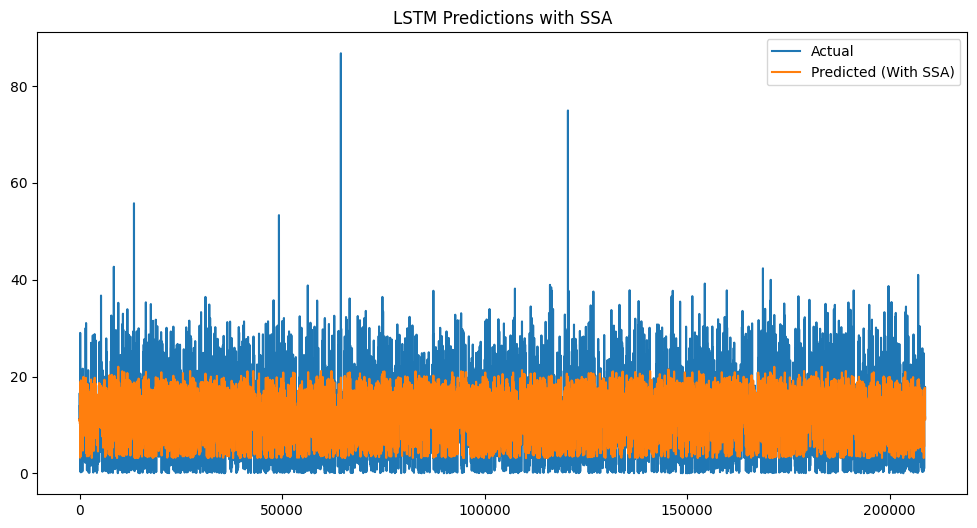

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the results
plt.plot(y_test_ssa_inverse, label='Actual')
plt.plot(y_pred_ssa_inverse, label='Predicted (With SSA)')
plt.title('LSTM Predictions with SSA')
plt.legend()
plt.show()


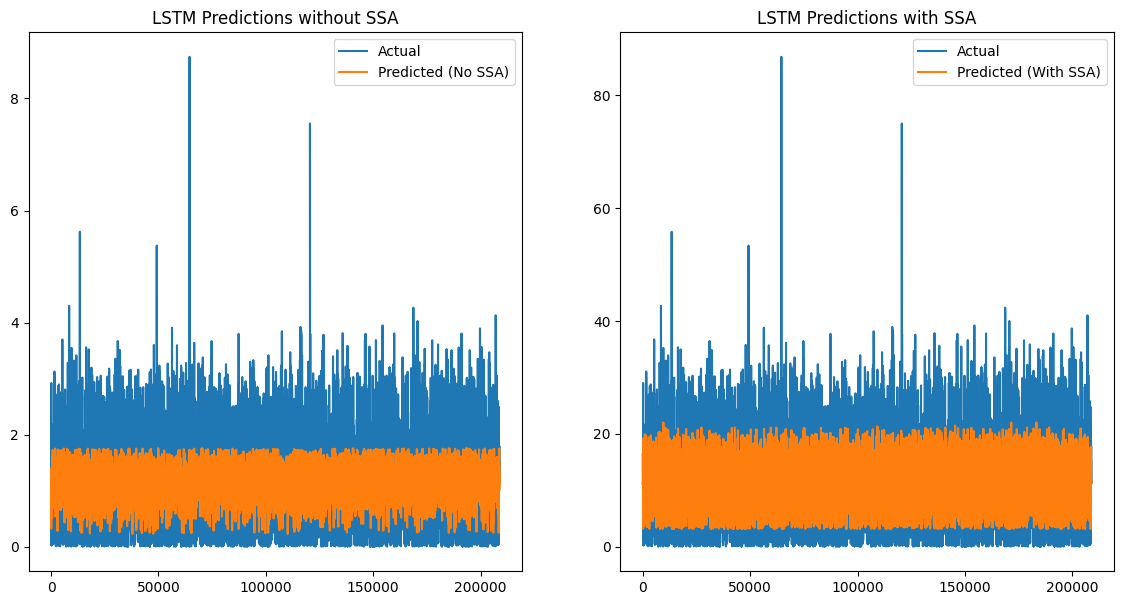

In [32]:
# Visualize the comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot predictions without SSA
plt.subplot(1, 2, 1)
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted (No SSA)')
plt.title('LSTM Predictions without SSA')
plt.legend()

# Plot predictions with SSA
plt.subplot(1, 2, 2)
plt.plot(y_test_ssa_inverse, label='Actual')
plt.plot(y_pred_ssa_inverse, label='Predicted (With SSA)')
plt.title('LSTM Predictions with SSA')
plt.legend()